In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
#look at first few rows of data
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
#get variable types and info
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

This dataset has 81 variables; 43 are string-type objects, 3 are floats, and 35 are integers.

In [5]:
#check for missing data
house_df.isnull().sum()*100/house_df.isnull().count()

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
                   ...    
bedroomabvgr      0.000000
kitchenabvgr      0.000000
kitchenqual       0.000000
totrmsabvgrd      0.000000
functional        0.000000
fireplaces        0.000000
f

Most of the variables do not have any missing values; however, some variables are missing values for more than 90% of the data. Those variables will probably not make sense to use as part of the linear regression. If we use variables that are missing a smaller part of the data for the linear regression, we will replace the missing values.

In [6]:
#get correlation between variables
house_df[['saleprice', 'id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond','yearbuilt', 
          'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf',
         'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
         'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
         'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold']].corr()

,saleprice,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,...,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold
saleprice,1.000000,-0.021917,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,...,0.623431,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923
id,-0.021917,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,...,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712
mssubclass,-0.084284,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,...,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
lotfrontage,0.351799,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,...,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450
lotarea,0.263843,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
overallqual,0.790982,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
overallcond,-0.077856,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,...,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
yearbuilt,0.522897,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
yearremodadd,0.507101,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,...,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
masvnrarea,0.477493,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,...,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201


First, I looked at the correlation between sale price and the numeric variables. Next, I narrowed this set of variables down to those that had the highest correlation with sale price.

In [7]:
#sale price correlation with selected variables
house_df[['saleprice', 'overallqual', 'totalbsmtsf', 'firstflrsf','grlivarea', 'garagecars', 'garagearea']].corr()

,saleprice,overallqual,totalbsmtsf,firstflrsf,grlivarea,garagecars,garagearea
saleprice,1.000000,0.790982,0.613581,0.605852,0.708624,0.640409,0.623431
overallqual,0.790982,1.000000,0.537808,0.476224,0.593007,0.600671,0.562022
totalbsmtsf,0.613581,0.537808,1.000000,0.819530,0.454868,0.434585,0.486665
firstflrsf,0.605852,0.476224,0.819530,1.000000,0.566024,0.439317,0.489782
grlivarea,0.708624,0.593007,0.454868,0.566024,1.000000,0.467247,0.468997
garagecars,0.640409,0.600671,0.434585,0.439317,0.467247,1.000000,0.882475
garagearea,0.623431,0.562022,0.486665,0.489782,0.468997,0.882475,1.000000


The variables that had the highest correlation with sale price were overall quality, total square feet of basement area, first floor square feet, above ground living area square feet, size of garage in car capacity, and size of garage in square feet. These are the numeric variables that will be used for the linear regression. Next, I will confirm that there are no missing values for these variables.

In [8]:
#confirm there are no missing values for selected variables
house_df[['saleprice', 'overallqual', 'totalbsmtsf', 'firstflrsf','grlivarea', 'garagecars', 
          'garagearea']].isnull().sum()*100/house_df[['saleprice', 'overallqual', 'totalbsmtsf', 'firstflrsf',
         'grlivarea', 'garagecars', 'garagearea']].isnull().count()

saleprice      0.0
overallqual    0.0
totalbsmtsf    0.0
firstflrsf     0.0
grlivarea      0.0
garagecars     0.0
garagearea     0.0
dtype: float64

There are no missing values for these variables that need to be replaced, so we can move on to looking at the non-numerical variables. 

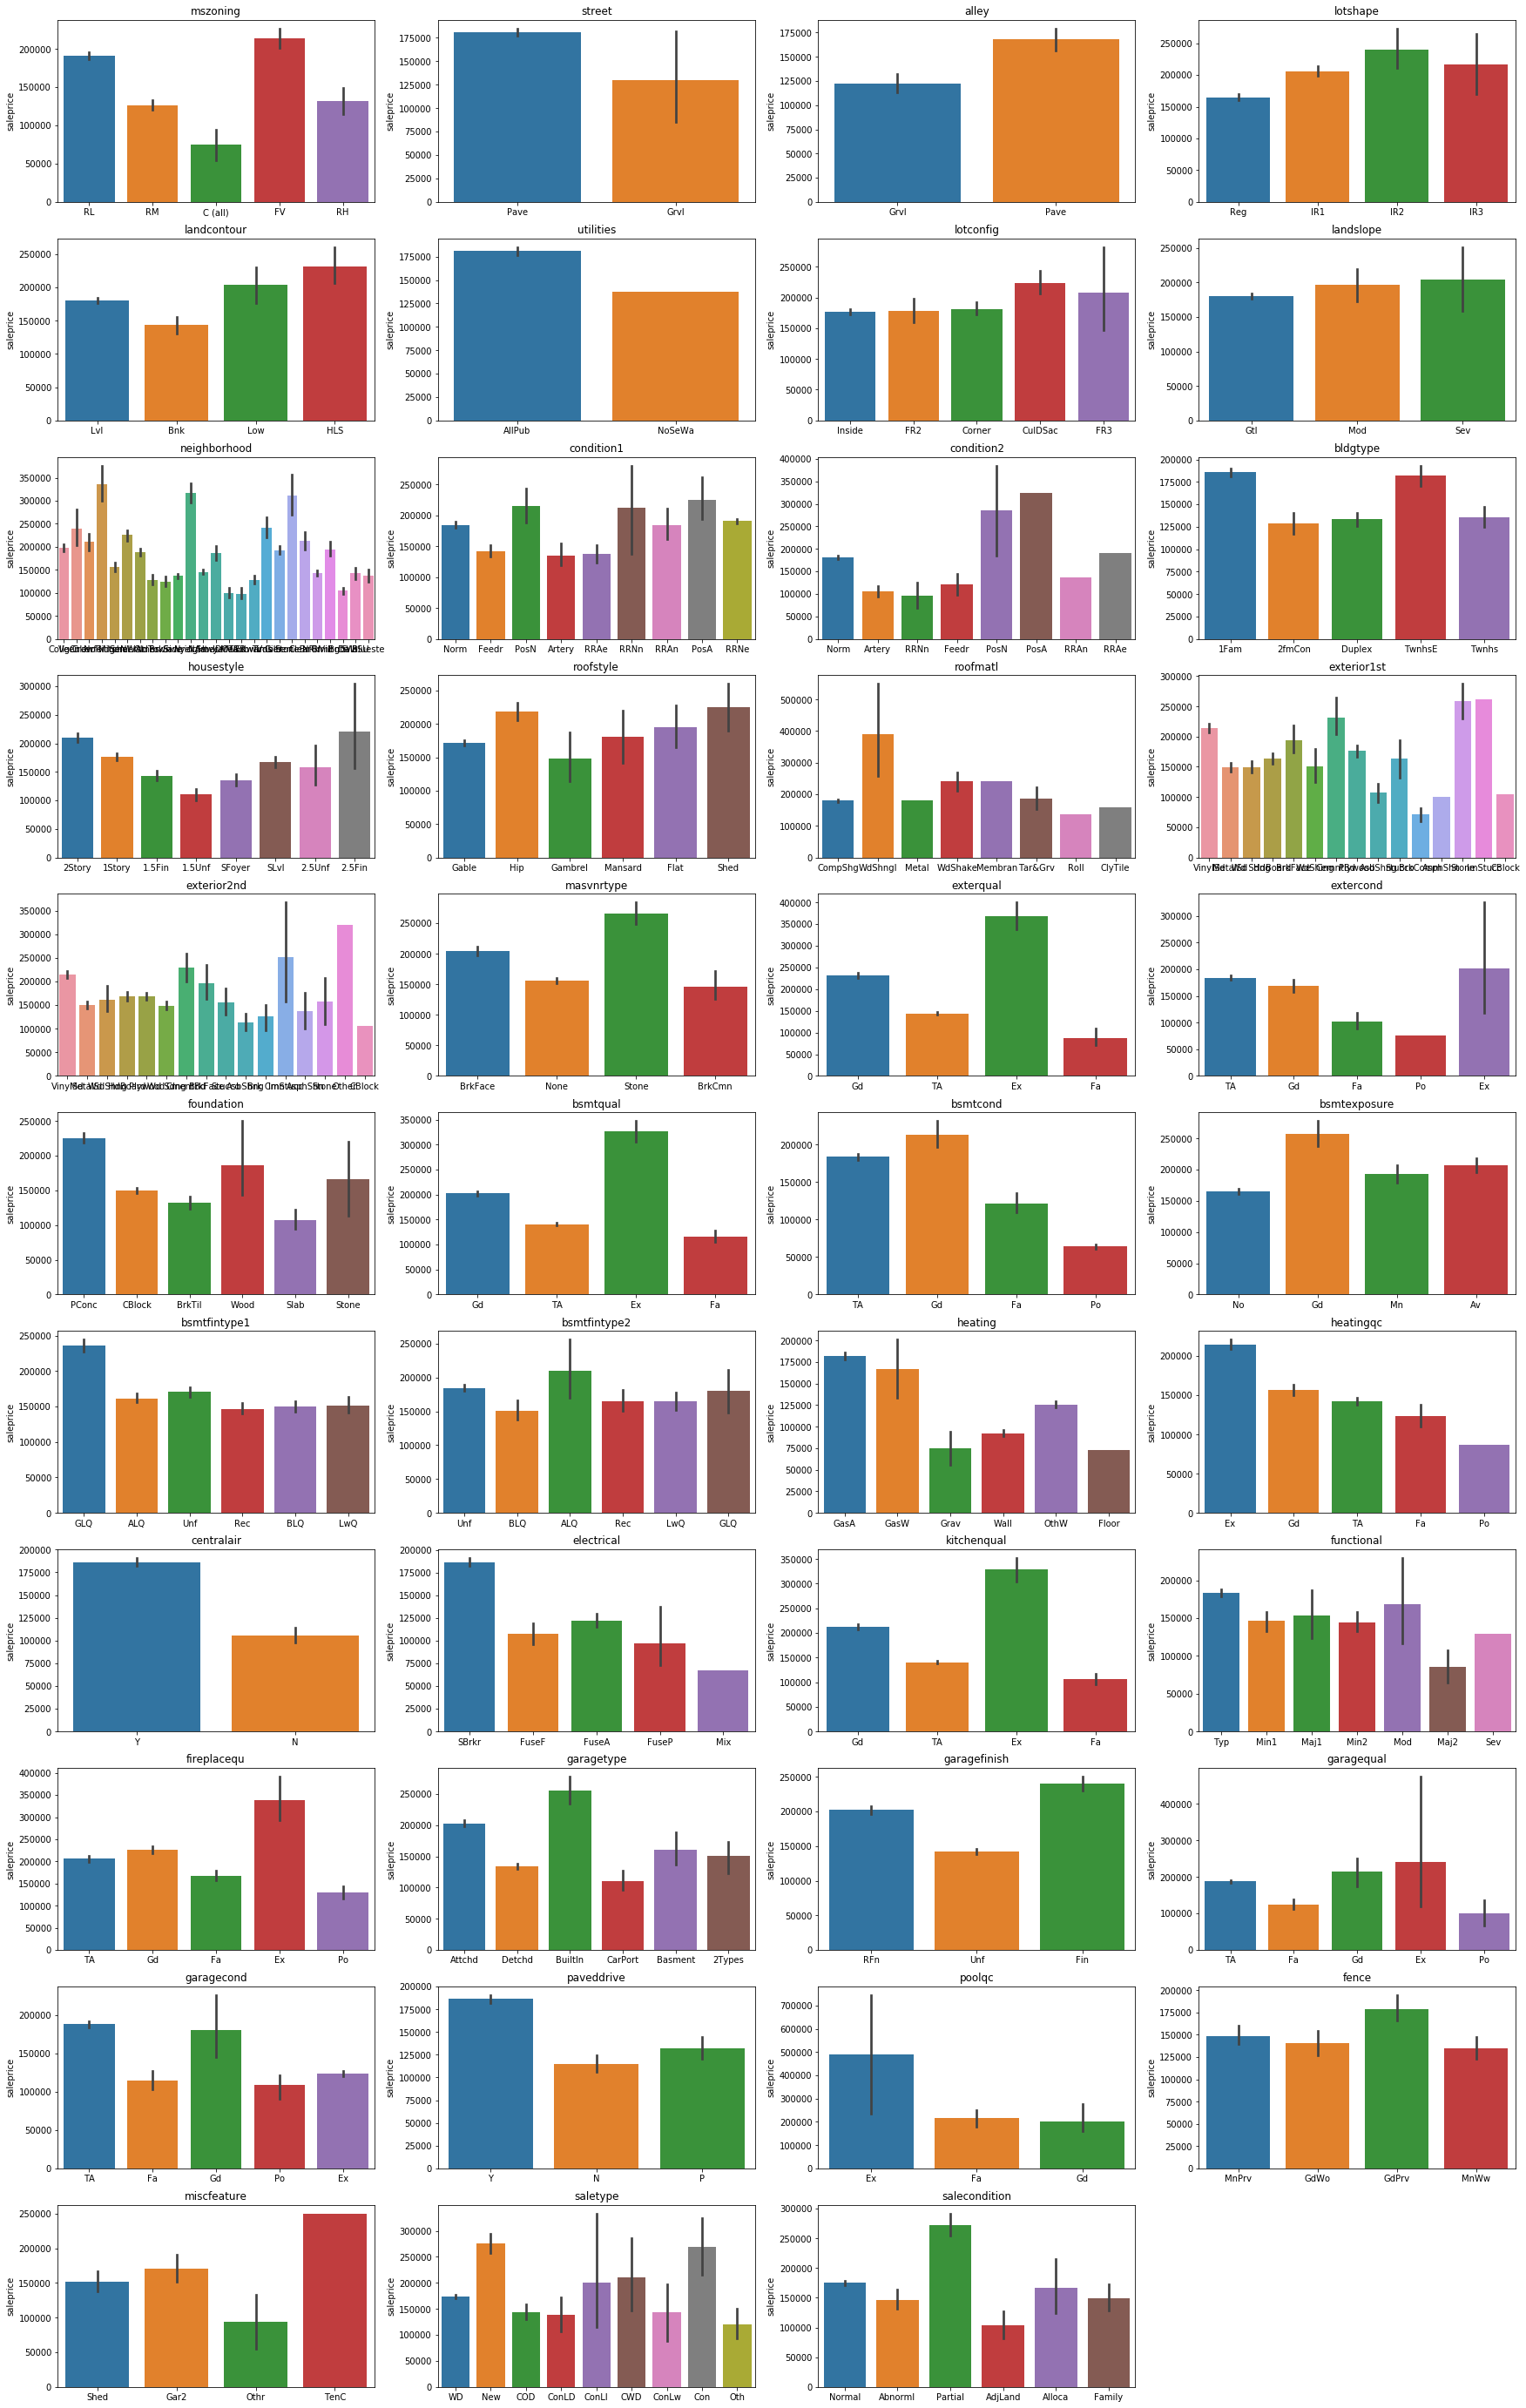

In [9]:
#plot of non-numerical variables
categories = ['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
             'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd',
             'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1',
             'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ',
             'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
             'saletype', 'salecondition']
plt.figure(figsize=(30,50))
for index, var in enumerate(categories):
    plt.subplot(11, 4, index+1)
    sns.barplot(house_df[var], house_df['saleprice'])
    plt.title(var)
    plt.xlabel('')

plt.show()

Based on the charts above, I will select variables that show differences between categories to include in the linear regression model.

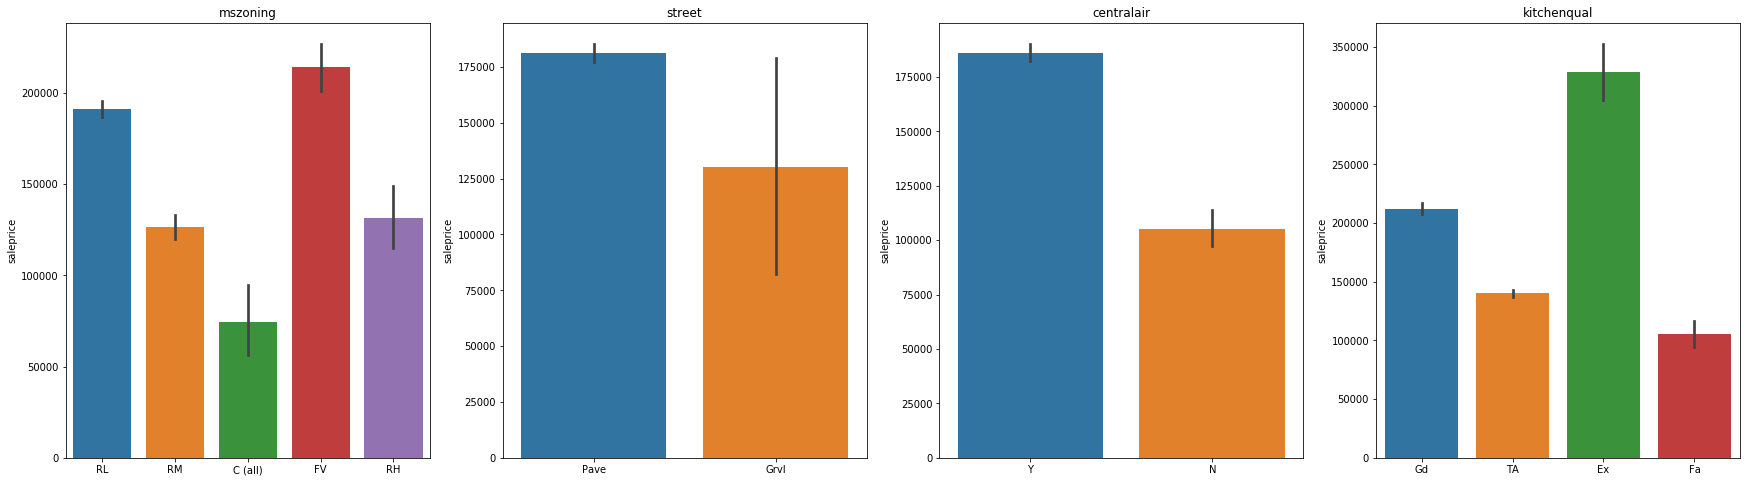

In [10]:
#plot selected variables
categories2 = ['mszoning', 'street','centralair', 'kitchenqual']
plt.figure(figsize=(30,8))
for index, var in enumerate(categories2):
    plt.subplot(1, 4, index+1)
    sns.barplot(house_df[var], house_df['saleprice'])
    plt.title(var)
    plt.xlabel('')

plt.show()

In [11]:
#confirm selected variables are not missing data
house_df[categories2].isnull().sum()*100/house_df[categories2].isnull().count()

mszoning       0.0
street         0.0
centralair     0.0
kitchenqual    0.0
dtype: float64

There are no missing values for the selected variables, so there is nothing that needs to be replaced. Next, I will create the necessary dummy variables to use in the linear regression.

In [12]:
#create dummy variables
house_df = pd.concat([house_df,pd.get_dummies(house_df.mszoning, prefix='mszoning', drop_first=True)], axis=1)
zoning_column_names = list(pd.get_dummies(house_df.mszoning, prefix='mszoning', drop_first=True).columns)
house_df['street_access'] = pd.get_dummies(house_df.street, drop_first=True)
house_df['has_AC'] = pd.get_dummies(house_df.centralair, drop_first=True)
house_df = pd.concat([house_df,pd.get_dummies(house_df.kitchenqual, prefix='kitchenqual', drop_first=True)], axis=1)
kitchen_column_names = list(pd.get_dummies(house_df.kitchenqual, prefix='kitchenqual', drop_first=True).columns)

In [13]:
#target variable
Y = house_df['saleprice']
#feature set
X = house_df[['overallqual', 'totalbsmtsf', 'firstflrsf','grlivarea', 'garagecars', 'garagearea', 
             'street_access', 'has_AC'] + zoning_column_names + kitchen_column_names]

#define linear model
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     371.8
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:49:35   Log-Likelihood:                -17390.
No. Observations:                1460   AIC:                         3.481e+04
Df Residuals:                    1444   BIC:                         3.490e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.691e+04   1.89e+04     -1.426      0.154   -6.39e+04    1.01e+04
overallqual     1.777e+04   1163.014     15.280      0.000    1.55e+04    2.01e+04
totalbsmtsf       20.6404      4.047      5.100      0.000      12.702      28.579
firstflrsf         4.3663      4.793      0.911      0.362      -5.035      13.767
grlivarea         44.4075      2.521     17.617      0.000      39.463      49.352
garagecars      1.419e+04   2843.841      4.990      0.000    8613.025    1.98e+04
garagearea         7.2384      9.889      0.732      0.464     -12.161      26.638
street_access  -5206.4437   1.54e+04     -0.337      0.736   -3.55e+04    2.51e+04
has_AC          1.016e+04   4306.673      2.358      0.018    1708.935    1.86e+04
mszoning_FV     2.667e+04   1.31e+04      2.037      0.042     984.253    5.24e+04
mszoning_RH     1.783e+04    1.5e+04      1.187      0.235   -1.16e+04    4.73e+04
mszoning_RL     2.903e+04   1.22e+04      2.378      0.018    5085.883     5.3e+04
mszoning_RM      1.04e+04   1.23e+04      0.846      0.398   -1.37e+04    3.45e+04
kitchenqual_Fa -5.643e+04   7971.778     -7.079      0.000   -7.21e+04   -4.08e+04
kitchenqual_Gd     -5e+04   4259.903    -11.738      0.000   -5.84e+04   -4.16e+04
kitchenqual_TA -6.321e+04   4826.914    -13.096      0.000   -7.27e+04   -5.37e+04
==============================================================================
Omnibus:                      500.709   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56929.274
Skew:                          -0.544   Prob(JB):                         0.00
Kurtosis:                      33.572   Cond. No.                     6.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""